# Edge response of three different reconstructed slices to access resolution/MTF
This [notebook](http://jupyter.org/) is used to asses the [Modulation transfer function](https://en.wikipedia.org/wiki/Optical_transfer_function) (MTF) of several different images.

In several slices of a tomographic dataset we gather line profiles from highly absorbing to lowly absorbing regions..
The 10--90% region of the edge response gives us a measure of the detectability of edges and thus resolution.

According [Quick MTF](http://www.quickmtf.com/about-resolution.html), an image quality testing application, we can easily use the edge profiles to get the modulation transfer function.
The first derivative of the edge spread function gives us the line spread function.
The 

To do so, we fit an [error function](https://en.wikipedia.org/wiki/Error_function) to the edge profile.
The first derivative of the edge profile gives us the line spread function.
By applying a discrete Fourier transform to the line spread function we receive the modulation transfer function.

In [1]:
# Hiding code in HTML export; from http://stackoverflow.com/a/34043321/323100
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di

di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

CSS = """#notebook div.output_subarea {max-width:100%;}""" #changes output_subarea width to 100% (from 100% - 14ex)
HTML('<style>{}</style>'.format(CSS))

In [2]:
# Import functions we need plus set defaults
import platform
import os
import glob
import numpy
import matplotlib.pylab as plt
%matplotlib inline
import seaborn
import scipy
from scipy.optimize import curve_fit
import skimage.measure

seaborn.set(context='notebook', style='dark') # http://seaborn.pydata.org/generated/seaborn.set.html#seaborn.set
plt.rc('image', cmap='gray', interpolation='nearest') # Display all images in b&w
plt.rcParams['figure.figsize'] = (16, 4)  # Size up figures a bit

In [3]:
# Load Images from different locations depending if we run this notebook on Linux or Windows
if 'debian' in platform.dist():
    RootFolder = '/home/habi/uCT-Archive-Online/'
else:
    RootFolder = 'O:/'
Folder = os.path.join(RootFolder, 'Temp')

/home/habi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: dist() and linux_distribution() functions are deprecated in Python 3.5
  


In [4]:
# Actually load the images now
ImageNames = sorted(glob.glob(os.path.join(Folder, '*.bmp')))
ImageNames += sorted(glob.glob(os.path.join(Folder, '*.png')))
ChosenImageNames = ImageNames
ChosenImages = [scipy.misc.imread(i, flatten=True) for i in ImageNames]
print('We found these images')
for i in ImageNames:
    print('\t- %s' % os.path.basename(i))

We found these images


For the found images, we selected the start- and end-coordinates of line profiles in [ImageJ](Fiji).
The images, the location of the profile line and a plot of the gray values along the chosen line is given below.

In [5]:
# In Fiji we selected the coordinates of the five randomly selected images.
# The start and end points of the line profiles from a filled blood vessel are given below,
# the line profiles are used for further calculations
StartPoint = [[2462,1590], [2207,3487], [2267,2323]]
EndPoint =   [[2512,1460], [2284,3316], [2105,2371]]

EdgeProfiles = [None] * len(ChosenImages)
for c,i in enumerate(ChosenImages):
    plt.subplot(121)
    plt.imshow(i)
    plt.plot([StartPoint[c][0], EndPoint[c][0]],[StartPoint[c][1], EndPoint[c][1]], color='red')
    plt.xlim([-1,numpy.shape(i)[0]])
    plt.ylim([numpy.shape(i)[1],-1])
    plt.title('%s with edge profile location' % os.path.basename(ChosenImageNames[c]))
    plt.subplot(122)
    EdgeProfiles[c] = skimage.measure.profile_line(i, StartPoint[c][::-1], EndPoint[c][::-1],
                                                   linewidth=5, order=3) # we flip the start and end point coordinates for matplotlib reasons
    plt.plot(EdgeProfiles[c])
    plt.xlabel('Pixel')
    plt.ylabel('Gray value')    
    plt.title('Edge profile')
    plt.ylim([0,254])
    plt.show()

The 10%-90%-distance of the edge height is a well-proven parameter to gain insight into the detectable width of features.
The plots below show the assessment of this distance.
We asses the mean gray value of the blood vessel and the mean gray value of the tissue (dotted lines in the plots below).
This gives us the gray value difference between the tissue and the blood vessels.
The locations of the 10% and 90% values are marked with yellow lines, the distance between is the edge width.
This edge width is multiplied by the pixel size, giving us a *conservative* measure of the smallest detectable feature in the dataset.

The 10-90% edge response (gray values 28-177) of the line profile in Kidney112_Left_NoF_79um__IR_rec1335.bmp is 7 pixels (0.00 um) wide (px 66-73)


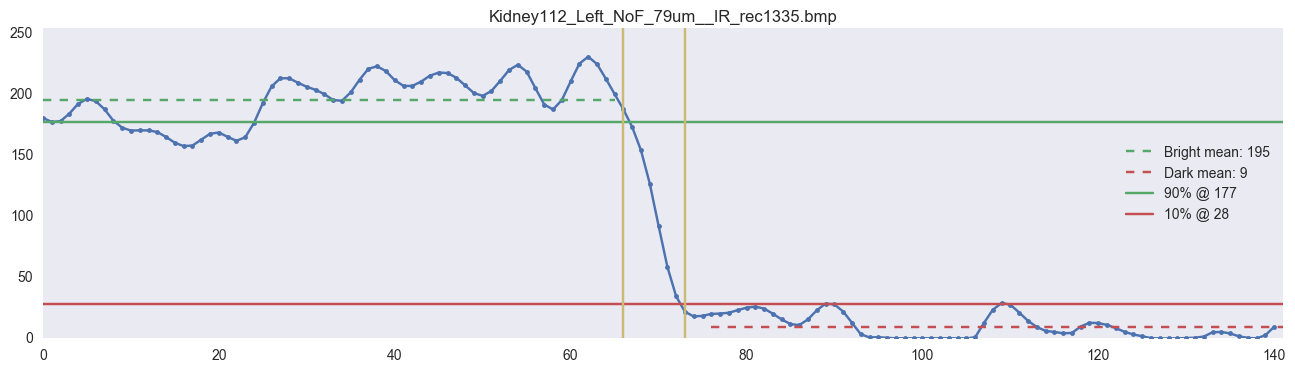

The 10-90% edge response (gray values 49-186) of the line profile in M12-Soleus-left-0-92um_IR_rec00001348.bmp is 8 pixels (0.00 um) wide (px 90-98)


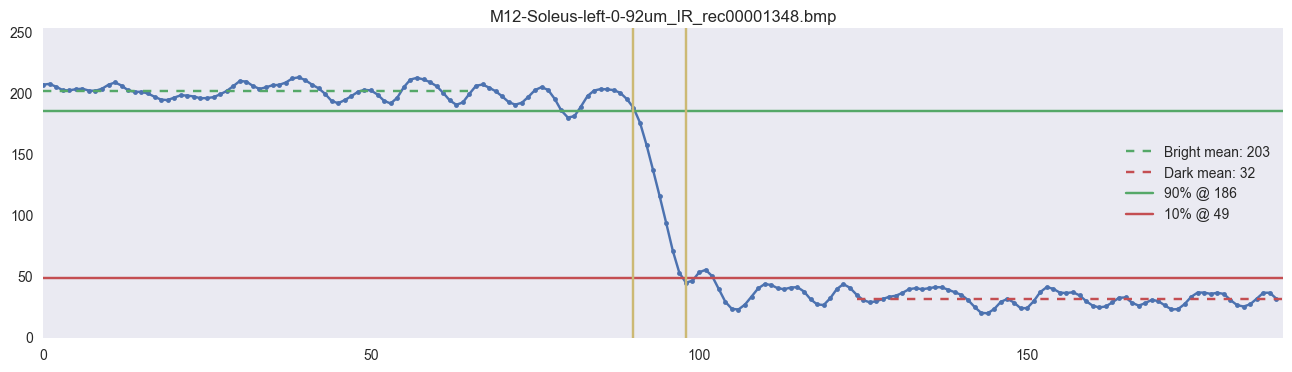

The 10-90% edge response (gray values 34-108) of the line profile in SpinalCord_lumbal_2um_Al05__rec00006030.png is 3 pixels (0.00 um) wide (px 78-81)


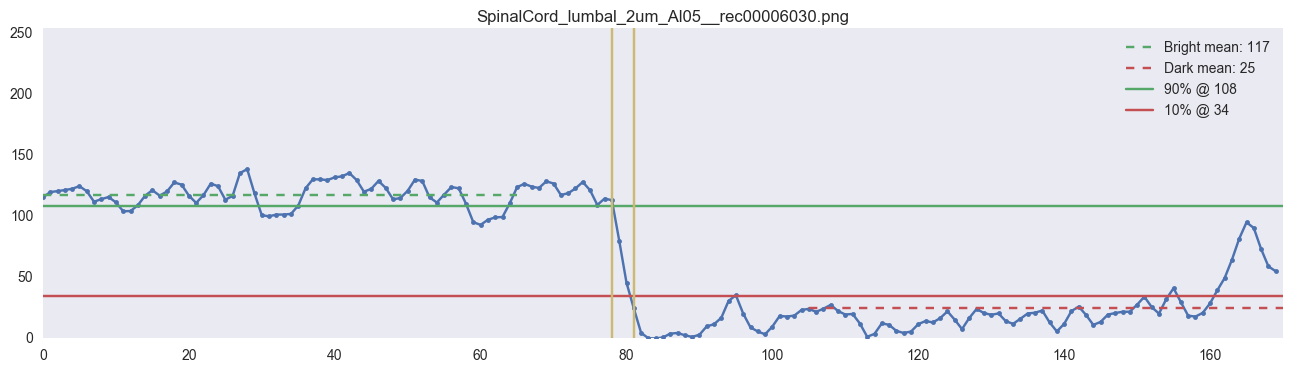

In [6]:
meancounter = 65
pixelsize = 0
for c,i in enumerate(EdgeProfiles):
    uaf_mean = numpy.mean(i[:meancounter])
    tissue_mean = numpy.mean(i[-meancounter:])
    mean_distance_drop = 0.1 * (uaf_mean - tissue_mean)
    start_of_edge = numpy.where(i>=(uaf_mean - mean_distance_drop))[0][-1]
    end_of_ege = numpy.where(i<=(tissue_mean + mean_distance_drop))[0][0]
    distance = end_of_ege - start_of_edge
    print('The 10-90%% edge response (gray values %0.f-%0.f) of the line profile in '
          '%s is %s pixels (%0.2f um) wide (px %s-%s)' % (tissue_mean + mean_distance_drop,
                                                          uaf_mean - mean_distance_drop,
                                                          os.path.basename(ChosenImageNames[c]),
                                                          distance,
                                                          distance * pixelsize,
                                                          start_of_edge,
                                                          end_of_ege))
    plt.plot(i, c=seaborn.color_palette()[0],marker='.')
    plt.axhline(y=uaf_mean,
                xmin=0,
                xmax=(float(meancounter)/len(EdgeProfiles[c])),
                c=seaborn.color_palette()[1], label='Bright mean: %0.f' % uaf_mean, ls='dashed')
    plt.axhline(y=tissue_mean,
                xmin=1-(float(meancounter)/len(EdgeProfiles[c])),
                xmax=len(EdgeProfiles[c]),
                c=seaborn.color_palette()[2], label='Dark mean: %0.f' % tissue_mean, ls='dashed')
    plt.axhline(uaf_mean - mean_distance_drop, c=seaborn.color_palette()[1],
                label='90%% @ %0.f' % (uaf_mean - mean_distance_drop))
    plt.axhline(tissue_mean + mean_distance_drop, c=seaborn.color_palette()[2],
                label='10%% @ %0.f' % (tissue_mean + mean_distance_drop))
    plt.axvline(start_of_edge, c=seaborn.color_palette()[4])    
    plt.axvline(end_of_ege, c=seaborn.color_palette()[4])
    plt.legend(loc='best')
    plt.title(os.path.basename(ChosenImageNames[c]))
    plt.xlim([0,len(i)])
    plt.ylim([0,254])
    plt.show()
    

By fitting an error function to the edge profile we can easily get a **smoothed** MTF of the data.
Additionally, we also plot the line spread function of the data and the fitted profile.
Keep in mind that the exact *location* of the edge is not crucial for the line spread function and MTF, the slope is more important.

In [7]:
def function_error(x, a, b):
    # Fit an error function (https://en.wikipedia.org/wiki/Error_function) to the data
    return a * scipy.special.erf(-x) + b

def fit_errorfunction(noisydata, scalefactor=0.5):
    start_of_edge = numpy.where(noisydata>=numpy.mean(noisydata[:meancounter]))[0][-1]
    end_of_edge = numpy.where(noisydata<=numpy.mean(noisydata[-meancounter:]))[0][0]
    edgelocation = start_of_edge + float(end_of_edge - start_of_edge)/2
    xdata = numpy.linspace(-scalefactor*edgelocation, scalefactor*(-edgelocation+len(noisydata)), len(noisydata))
    popt, pcov = curve_fit(function_error, xdata, noisydata)
    return popt[0] * scipy.special.erf(-xdata)+popt[1]

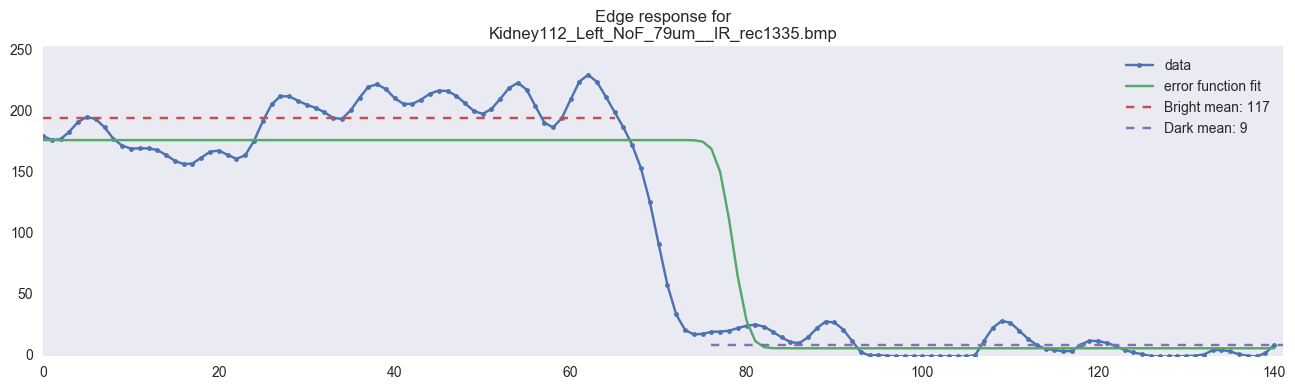

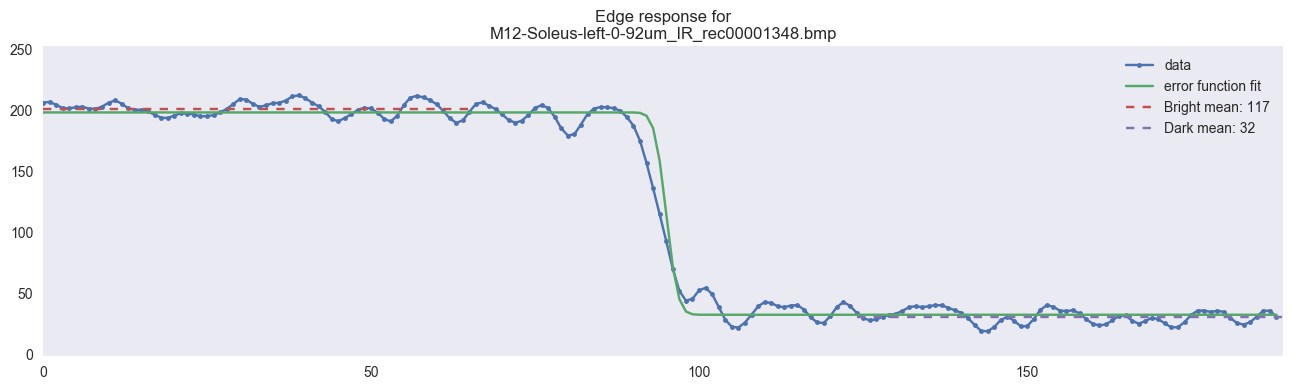

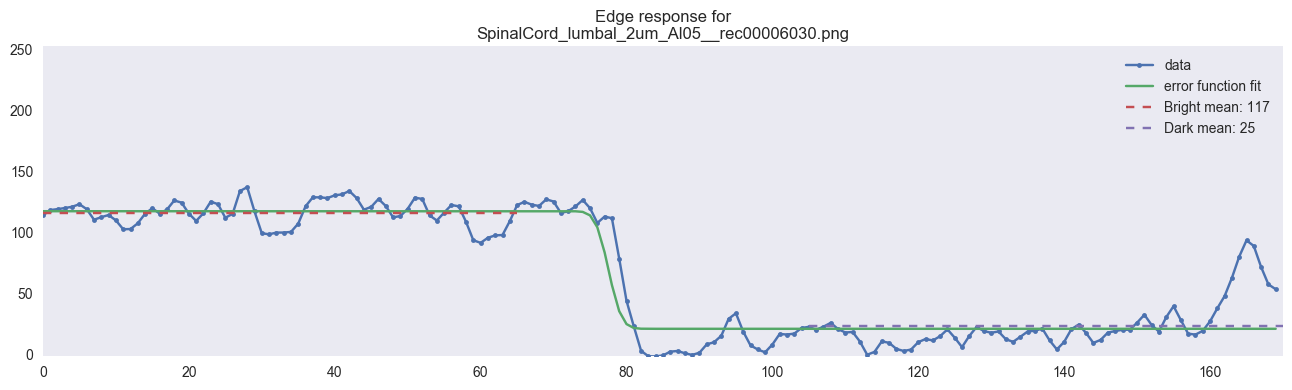

In [8]:
for c,i in enumerate(EdgeProfiles):
#     plt.subplot(1,len(EdgeProfiles),c+1)
    plt.plot(i, label='data', marker='.')
    plt.plot(fit_errorfunction(i), label='error function fit')
    plt.axhline(y=numpy.mean(i[:meancounter]),
                xmin=0,
                xmax=(float(meancounter)/len(EdgeProfiles[c])),
                c=seaborn.color_palette()[2], label='Bright mean: %0.f' % uaf_mean, ls='dashed')
    plt.axhline(y=numpy.mean(i[-meancounter:]),
                xmin=1-(float(meancounter)/len(EdgeProfiles[c])),
                xmax=len(EdgeProfiles[c]),
                c=seaborn.color_palette()[3], label='Dark mean: %0.f' % numpy.mean(i[-meancounter:]), ls='dashed')   
    plt.legend(loc='best')
    plt.title('Edge response for\n%s' % os.path.basename(ChosenImageNames[c]))
    plt.xlim([0,len(i)])
    plt.ylim([0,254])    
    plt.show()

In [9]:
def linespread_function(data):
    return numpy.diff(data)

def mtf(data):
    return numpy.abs(numpy.fft.fft(linespread_function(data)))

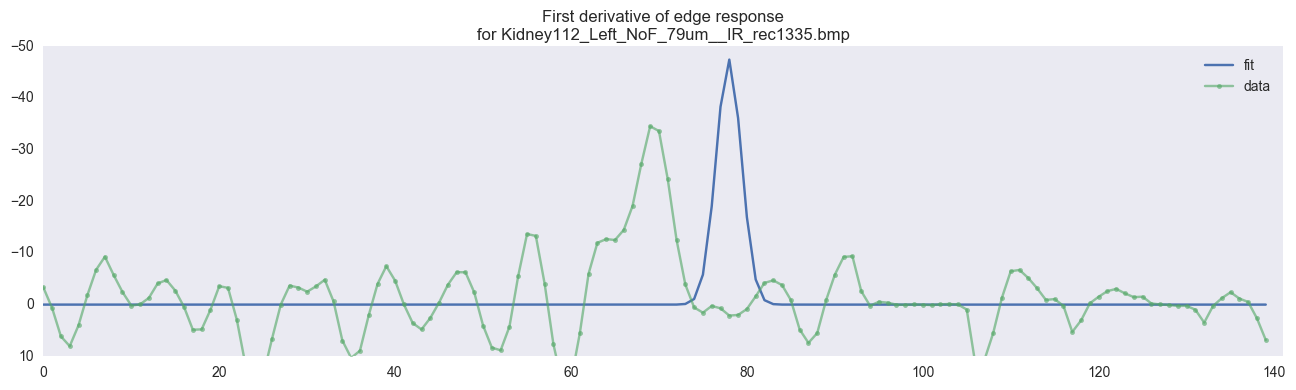

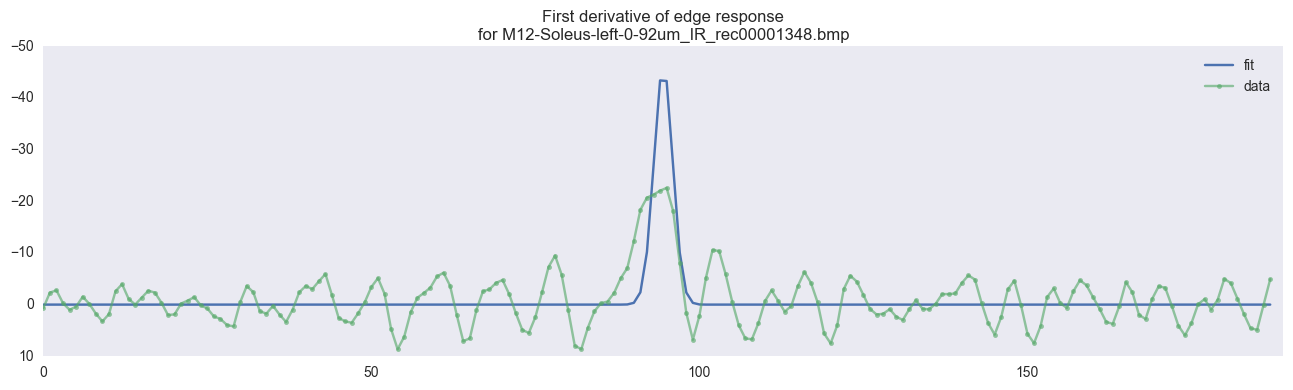

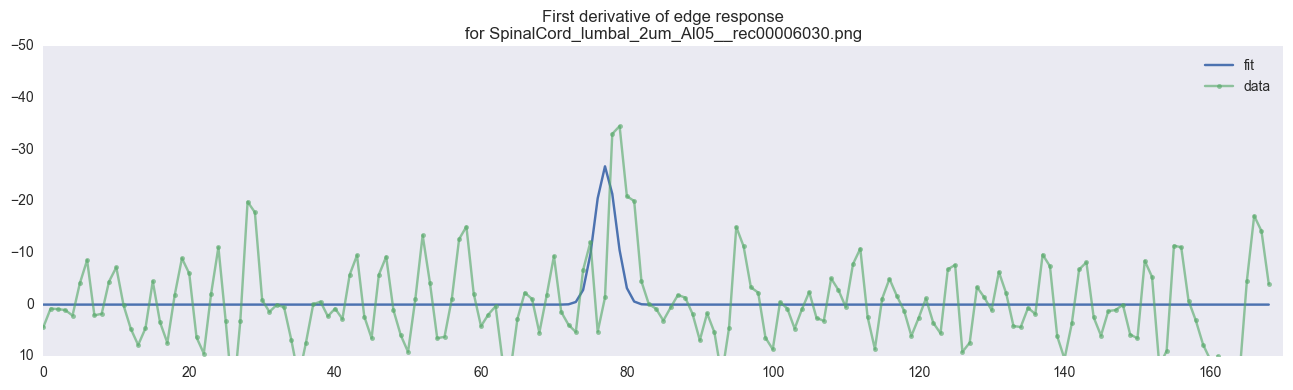

In [10]:
for c, i in enumerate(EdgeProfiles):
#     plt.subplot(1, len(EdgeProfiles),c+1)
    plt.plot(linespread_function(fit_errorfunction(i)), label='fit')
    plt.plot(linespread_function(i), label='data', alpha=0.618, marker='.')
    plt.legend(loc='best')
    plt.title('First derivative of edge response\nfor %s' % os.path.basename(ChosenImageNames[c]))
    plt.xlim([0,len(i)])
    plt.ylim([10,-50])
    plt.show()

By fitting a [6th order polynomial](https://en.wikipedia.org/wiki/Optical_transfer_function#Numerical_evaluation) to the MTF data we can get a smoothed version of the MTF for the real data.
The MTF of the error function fit is also shown in the plots below.

In [11]:
def function_polynomial(x, a, b, c, d, e, f, g):
    # Fit a sixth order polynomial to the data
    return a * x**6 + b * x**5 + c * x**4 + d * x**3 + e * x**2 + f * x + g

def fit_polynomial(noisydata):
    start_of_edge = numpy.where(noisydata>numpy.mean(noisydata[:meancounter]))[0][-1]
    end_of_ege = numpy.where(noisydata<numpy.mean(noisydata[-meancounter:]))[0][0]
    edgelocation = start_of_edge + (end_of_ege - start_of_edge)/2
    xdata = numpy.linspace(-edgelocation, -edgelocation+len(noisydata), len(noisydata))   
    popt, pcov = curve_fit(function_polynomial, xdata, noisydata)
    return(popt[0] * xdata**6 +
           popt[1] * xdata**5 +
           popt[2] * xdata**4 +
           popt[3] * xdata**3 +
           popt[4] * xdata**2 +
           popt[5] * xdata +
           popt[6])

In [12]:
plt.rcParams['figure.figsize'] = (6, 6)  # Size up figures a bit

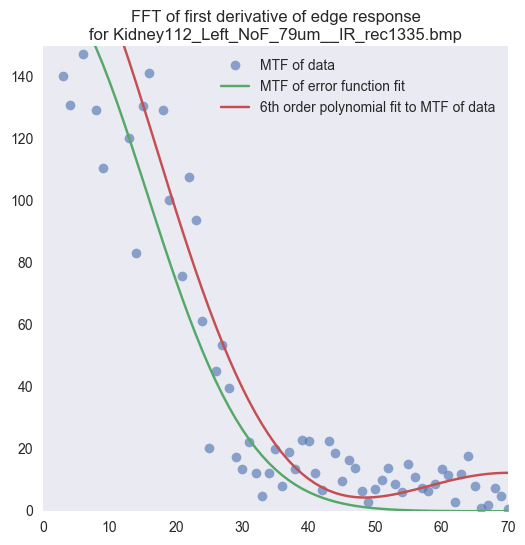

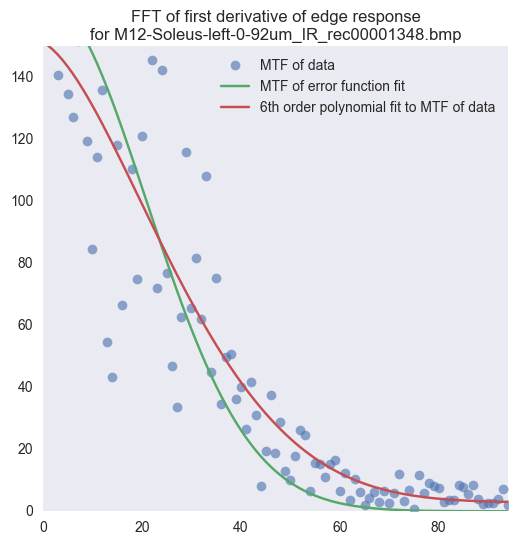

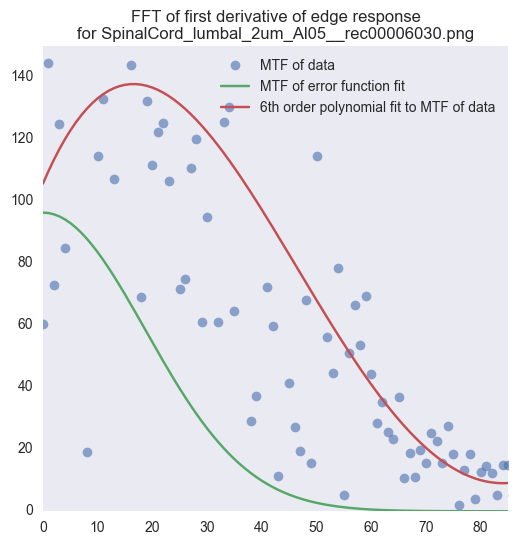

In [13]:
for c, i in enumerate(EdgeProfiles):
#     plt.subplot(1, len(EdgeProfiles),c+1)
    plt.plot(mtf(i), label='MTF of data', alpha=0.618, marker='o', ls='')    
    plt.plot(mtf(fit_errorfunction(i)), label='MTF of error function fit')
    plt.plot(fit_polynomial(mtf(i)), label='6th order polynomial fit to MTF of data')
    plt.legend(loc='best')
    plt.title('FFT of first derivative of edge response\nfor %s' % os.path.basename(ChosenImageNames[c]))
    plt.xlim([0,len(i)//2])    
    plt.ylim([0,150])
    plt.legend(loc='best')
    plt.show()